## Tutorial in [Visual Studio Code, on Data Science](https://code.visualstudio.com/docs/python/data-science-tutorial)

Requisite, install these packages:
pandas, jupyter, seaborn, scikit-learn, keras, and tensorflow

This tutorial uses the [Titanic dataset](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.html) available on [OpenML.org](https://www.openml.org/d/40945), which is obtained from Vanderbilt University's Department of Biostatistics at http://biostat.mc.vanderbilt.edu/DataSets. The Titanic data provides information about the survival of passengers on the Titanic, as well as characteristics about the passengers such as age and ticket class. Using this data, the tutorial will establish a model for predicting whether a given passenger would have survived the sinking of the Titanic.

For additional information about the data set, refer to [this document](http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3info.txt) about how it was constructed.

### Prepare the data

In [1]:
import pandas as pd
import numpy as np

# data.csv is the data we will be work with. The Titanic dataset.
# data will be a Panda DataFrame
data = pd.read_csv('datasets/data.csv')

Before working with the data, we need to make sure that there aren't any issues with it. If you look at the Titanic csv file, you'll notice is that a question mark ("?") was used to designate cells where data wasn't available.

Replace the question marks in the age and fare columns with the [numpy NaN](https://docs.scipy.org/doc/numpy/reference/constants.html?highlight=nan#numpy.nan) value.

In [2]:
data.replace('?', np.nan, inplace=True)
data = data.astype({"age": np.float64, "fare": np.float64})

View how certain columns of the dataset relate to survivability.

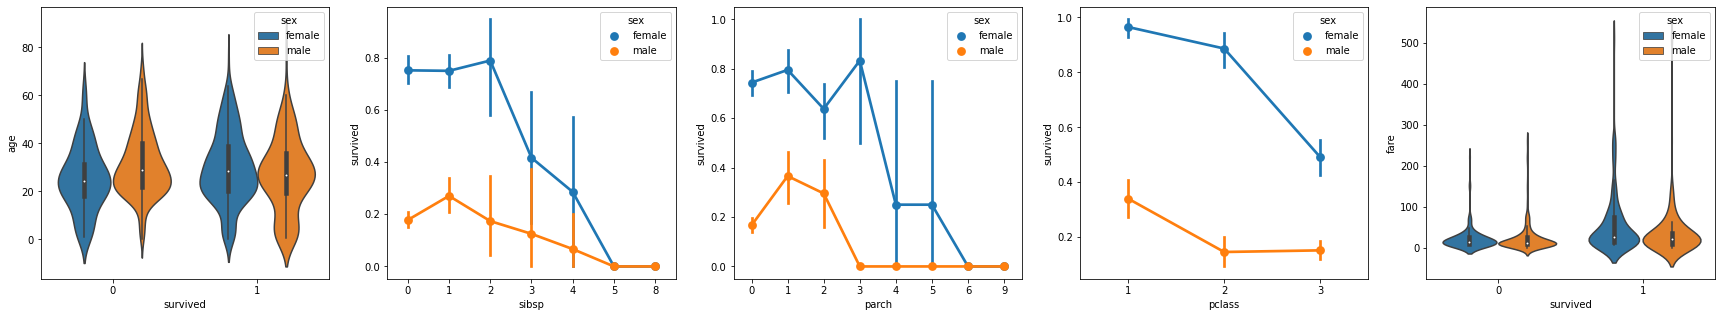

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=5, figsize=(30,5))
sns.violinplot(x="survived", y="age", hue="sex", data=data, ax=axs[0])
sns.pointplot(x="sibsp", y="survived", hue="sex", data=data, ax=axs[1])
sns.pointplot(x="parch", y="survived", hue="sex", data=data, ax=axs[2])
sns.pointplot(x="pclass", y="survived", hue="sex", data=data, ax=axs[3])
sns.violinplot(x="survived", y="fare", hue="sex", data=data, ax=axs[4])

Use pandas to calculate correlation between survival and the input variables of the data. To do so, all the variables used need to be numeric for the correlation calculation and currently gender is stored as a string. Convert those string values to integers.

In [4]:
data.replace({'male': 1, 'female': 0}, inplace=True)

Analyze the correlation between all the input variables to identify the features that would be the best inputs to a machine learning model. The closer a value is to 1, the higher the correlation between the value and the result.

In [5]:
data.corr().abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055513
sibsp,0.027825
parch,0.082660
fare,0.244265


Notice that some variables like gender have a fairly high correlation to survival, while others like relatives (sibsp = siblings or spouse, parch = parents or children) seem to have little correlation.

Let's hypothesize that sibsp and parch are related in how they affect survivability, and group them into a new column called "relatives" to see whether the combination of them has a higher correlation to survivability. To do this, you will check if for a given passenger, the number of sibsp and parch is greater than 0 and, if so, you can then say that they had a relative on board.

So, create a new variable and column in the dataset called `relatives` and check the correlation again.

In [6]:
data['relatives'] = data.apply (lambda row: int((row['sibsp'] + row['parch']) > 0), axis=1)
data.corr().abs()[["survived"]]

,survived
pclass,0.312469
survived,1.000000
sex,0.528693
age,0.055513
sibsp,0.027825
parch,0.082660
fare,0.244265
relatives,0.201719


Notice that in fact when looked at from the standpoint of whether a person had relatives, versus how many relatives, there is a higher correlation with survival. With this information in hand, you can now drop from the dataset the low value sibsp and parch columns, as well as any rows that had NaN values, to end up with a dataset that can be used for training a model.

In [7]:
data = data[['sex', 'pclass','age','relatives','fare','survived']].dropna()

### Train and evaluate a model

Steps:
* pre-processing of the dataset, 
* train a classification model to determine survivability on the Titanic, 
* and then use that model with test data to determine its accuracy.

Will use [scikit-learn](https://scikit-learn.org/stable/)

Divide up the dataset into training and validation data. 
This allows you to use a portion of the data to train the model and a portion of the data to test the model. If you used all your data to train the model, you wouldn't have a way to estimate how well it would actually perform against data the model has not yet seen.

Scikit-learn library provides a method specifically for splitting a dataset into training and test data.


In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data[['sex','pclass','age','relatives','fare']], data.survived, test_size=0.2, random_state=0)

Normalize the inputs such that all features are treated equally. For example, within the dataset the values for age range from ~0-100, while gender is only a 1 or 0. By normalizing all the variables, you can ensure that the ranges of values are all the same. 

In [9]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(x_train)
X_test = sc.transform(x_test)

Apply a machine learning algorithm to the data.

There are a number of different machine learning algorithms that you could choose from to model the data and scikit-learn provides support for a number of [them](https://scikit-learn.org/stable/user_guide.html), as well as a [chart](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to help select the one that's right for your scenario. 

For now, use the [Naïve Bayes](https://scikit-learn.org/stable/modules/naive_bayes.ntml) algorithm, a common algorithm for classification problems. 

In [10]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

With a trained model, you can now try it against the test data set that was held back from training.
We will now predict the outcome of the test data and calculate the accuracy of the model.

In [11]:
from sklearn import metrics

predict_test = model.predict(X_test)
print(metrics.accuracy_score(y_test, predict_test))

0.7464114832535885


### Use a neural network to increase accuracy

A neural network is a model that uses weights and activation functions, modeling aspects of human neurons, to determine an outcome based on provided inputs. 

Unlike the machine learning algorithm you looked at previously, neural networks are a form of deep learning wherein you don't need to know an ideal algorithm for your problem set ahead of time. It can be used for many different scenarios and classification is one of them. 

For this section, you'll use the [Keras](https://keras.io/) library with [TensorFlow](https://www.tensorflow.org/) to construct the neural network, and explore how it handles the Titanic dataset.

Import the required libraries and create the model. 

In this case, you'll use a [Sequential](https://keras.io/getting-started/sequential-model-guide/) neural network, which is a layered neural network wherein there are multiple layers that feed into each other in sequence.

In [12]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

Using TensorFlow backend.


The next step is to add the layers of the neural network. 

For now, let's keep things simple and just use three layers. 

In [13]:
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu', input_dim = 5))
model.add(Dense(5, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(1, kernel_initializer = 'uniform', activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 66
Trainable params: 66
Non-trainable params: 0
_________________________________________________________________


Once the model is created, it needs to be compiled. 

As part of this, you need to define what type of optimizer will be used, how loss will be calculated, and what metric should be optimized for. 

In [14]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
836/836 [==============================] - 0s 299us/step - loss: 0.6923 - accuracy: 0.5849
Epoch 2/50
836/836 [==============================] - 0s 78us/step - loss: 0.6900 - accuracy: 0.5861
Epoch 3/50
836/836 [==============================] - 0s 89us/step - loss: 0.6858 - accuracy: 0.5885
Epoch 4/50
836/836 [==============================] - 0s 86us/step - loss: 0.6776 - accuracy: 0.6471
Epoch 5/50
836/836 [==============================] - 0s 87us/step - loss: 0.6633 - accuracy: 0.7404
Epoch 6/50
836/836 [==============================] - 0s 84us/step - loss: 0.6424 - accuracy: 0.7715
Epoch 7/50
836/836 [==============================] - 0s 77us/step - loss: 0.6168 - accuracy: 0.7727
Epoch 8/50
836/836 [==============================] - 0s 135us/step - loss: 0.5886 - accuracy: 0.7727
Epoch 9/50
836/836 [==============================] - 0s 124us/step - loss: 0.5619 - accuracy: 0.7739
Epoch 10/50
836/836 [==============================] - 0s 109us/step - loss: 0.5373 - ac

With the model built and trained its now time to see how it performs against the test data.

In [15]:
y_pred = model.predict_classes(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.7799043062200957
